In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
import json
import logging
import os
from tqdm import tqdm

ModuleNotFoundError: No module named 'tarfile'

In [2]:
# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class CodeDocstringEncoder(nn.Module):
    def __init__(self, model_name="answerdotai/ModernBERT-base"):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        # Use CLS token embedding as sequence representation
        return outputs.last_hidden_state[:, 0]

In [3]:
class ContrastiveModel(nn.Module):
    def __init__(self, model_name="answerdotai/ModernBERT-base"):
        super().__init__()
        self.code_encoder = CodeDocstringEncoder(model_name)
        self.docstring_encoder = CodeDocstringEncoder(model_name)
        
    def forward(self, code_ids, code_mask, doc_ids, doc_mask):
        code_emb = self.code_encoder(code_ids, code_mask)
        doc_emb = self.docstring_encoder(doc_ids, doc_mask)
        return code_emb, doc_emb


In [4]:
def contrastive_loss(code_emb, doc_emb, temperature=0.07):
    # Normalize embeddings
    code_emb = nn.functional.normalize(code_emb, dim=1)
    doc_emb = nn.functional.normalize(doc_emb, dim=1)
    
    # Compute similarity matrix
    similarity = torch.matmul(code_emb, doc_emb.T) / temperature
    
    # Labels: diagonal elements are positive pairs
    labels = torch.arange(similarity.size(0), device=similarity.device)
    
    # Compute cross entropy loss in both directions
    loss = (
        nn.functional.cross_entropy(similarity, labels) + 
        nn.functional.cross_entropy(similarity.T, labels)
    ) / 2
    
    return loss

In [5]:
class CodeDocstringDataset(Dataset):
    def __init__(self, json_path, tokenizer_name="answerdotai/ModernBERT-base", max_length=512):
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length
        
        # Load JSON data
        logger.info(f"Loading data from {json_path}")
        with open(json_path, 'r') as f:
            self.data = json.load(f)
        # take 1000 examples
        self.data = self.data[:1000]
        logger.info(f"Loaded {len(self.data)} examples")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        code = item['code']
        docstring = item['docstring']
        
        # Tokenize inputs
        code_tokens = self.tokenizer(
            code,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        doc_tokens = self.tokenizer(
            docstring,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'code_input_ids': code_tokens['input_ids'].squeeze(0),
            'code_attention_mask': code_tokens['attention_mask'].squeeze(0),
            'doc_input_ids': doc_tokens['input_ids'].squeeze(0),
            'doc_attention_mask': doc_tokens['attention_mask'].squeeze(0)
        }


In [ ]:
# Create dataset instance
json_path = "../dual_encoder_data/json/python_train_0.json"
max_length = 50  # Small length for demonstration
dataset = CodeDocstringDataset(json_path=json_path, max_length=max_length)

# Get the first item
sample = dataset[0]

# Print the results
print("Original code (truncated):", dataset.data[0]['code'][:50], "...")
print("\nCode input ids:", sample['code_input_ids'])
print("Code attention mask:", sample['code_attention_mask'])
print("\nOriginal docstring (truncated):", dataset.data[0]['docstring'][:50], "...")
print("Docstring input ids:", sample['doc_input_ids'])
print("Docstring attention mask:", sample['doc_attention_mask'])

# Decode the tokens to see what they represent
print("\nDecoded code tokens:", dataset.tokenizer.convert_ids_to_tokens(sample['code_input_ids']))
print("Decoded docstring tokens:", dataset.tokenizer.convert_ids_to_tokens(sample['doc_input_ids']))

In [7]:
def train_step(model, batch, optimizer):
    code_ids, code_mask = batch['code_input_ids'], batch['code_attention_mask']
    doc_ids, doc_mask = batch['doc_input_ids'], batch['doc_attention_mask']
    
    code_emb, doc_emb = model(code_ids, code_mask, doc_ids, doc_mask)
    loss = contrastive_loss(code_emb, doc_emb)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [8]:
def train_model(train_json_path, 
                model_save_dir,
                batch_size=16,
                num_epochs=10,
                learning_rate=2e-5,
                model_name="answerdotai/ModernBERT-base",
                max_length=128):
    
    # Create save directory if it doesn't exist
    os.makedirs(model_save_dir, exist_ok=True)
    
    # Set device
    device = torch.device('mps' if torch.mps.is_available() else 'cpu')
    logger.info(f"Using device: {device}")
    
    # Initialize dataset and dataloader
    dataset = CodeDocstringDataset(train_json_path, model_name, max_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model
    model = ContrastiveModel(model_name).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    # Training loop
    logger.info("Starting training...")
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")
        
        for batch_idx, batch in enumerate(progress_bar):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Training step
            loss = train_step(model, batch, optimizer)
            total_loss += loss
            
            # Update progress bar
            progress_bar.set_postfix({'loss': f'{loss:.4f}'})
            
        avg_loss = total_loss / len(dataloader)
        logger.info(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
        
        # Save checkpoint
        checkpoint_path = os.path.join(model_save_dir, f'checkpoint_epoch_{epoch+1}.pt')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
        logger.info(f"Saved checkpoint to {checkpoint_path}")
    
    # Save final model
    final_model_path = os.path.join(model_save_dir, 'final_model.pt')
    torch.save(model.state_dict(), final_model_path)
    logger.info(f"Training completed. Final model saved to {final_model_path}")
    
    return model

In [9]:
def main():
    # Training configuration
    config = {
        'train_json_path': '../dual_encoder_data/json/python_train_0.json',
        'model_save_dir': './code_docstring_model',
        'batch_size': 16,
        'num_epochs': 3,
        'learning_rate': 2e-5,
        'model_name': "answerdotai/ModernBERT-base",
        'max_length': 128
    }
    
    # Train the model
    trained_model = train_model(**config)
    
    return trained_model

if __name__ == "__main__":
    main()

INFO:__main__:Using device: mps
INFO:__main__:Loading data from ../dual_encoder_data/json/python_train_0.json
INFO:__main__:Loaded 1000 examples
INFO:__main__:Starting training...
Epoch 1/3:   0%|          | 0/63 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 1/3: 100%|██████████| 63/63 [01:34<00:00,  1.49s/it, loss=0.0095]
INFO:__main__:Epoch 1/3, Average Loss: 0.3909
INFO:__main__:Saved checkpoint to ./code_docstring_model/checkpoint_epoch_1.pt
Epoch 2/3: 100%|██████████| 63/63 [01:34<00:00,  1.49s/it, loss=0.0015]
INFO:__main__:Epoch 2/3, Average Loss: 0.0122
INFO:__main__:Saved checkpoint to ./code_docstring_model/checkpoint_epoch_2.pt
Epoch 3/3: 100%|██████████| 63/63 [01:33<00:00,  1.49

In [10]:
import ast
from pathlib import Path


class CodeRetriever:
    def __init__(self, model_path: str, device = None):
        if device is None:
            self.device = torch.device('mps' if torch.mps.is_available() else 'cpu')
        else:
            self.device = torch.device(device)
        
        self.model = self.load_model(model_path)
        self.tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
        self.function_embeddings = None
        self.docstring_embeddings = None

    def load_model(self, model_path: str):
        model = ContrastiveModel("answerdotai/ModernBERT-base").to(self.device)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        return model
    
    def compute_embeddings(self, text: str, is_code:bool = True):
        tokens = self.tokenizer(
            text,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        ).to(self.device)

        with torch.no_grad():
            if is_code:
                embeddings = self.model.code_encoder(tokens['input_ids'], tokens['attention_mask'])
            else:
                embeddings = self.model.docstring_encoder(tokens['input_ids'], tokens['attention_mask'])
        return embeddings




In [11]:

retriever = CodeRetriever("./code_docstring_model/final_model.pt")

code = """def unpersist(self, blocking=False):
        self.is_cached = False
        self._jrdd.unpersist(blocking)
        return self"""

docstring = """Mark the RDD as non-persistent, and remove all blocks for it from
        memory and disk."""


code_embedding = retriever.compute_embeddings(code, is_code=True)
docstring_embedding = retriever.compute_embeddings(docstring, is_code=False)


print(f"Code embedding shape: {code_embedding.shape}")
print(f"Docstring embedding shape: {docstring_embedding.shape}")



Code embedding shape: torch.Size([1, 768])
Docstring embedding shape: torch.Size([1, 768])


In [12]:
similarity = torch.nn.functional.cosine_similarity(code_embedding, docstring_embedding)
print(f"Similarity between code and docstring: {similarity.item():.4f}")

Similarity between code and docstring: 0.5120


In [13]:
code_2="def _load_from_socket(port, auth_secret):\n    \"\"\"\n    Load data from a given socket, this is a blocking method thus only return when the socket\n    connection has been closed.\n    \"\"\"\n    (sockfile, sock) = local_connect_and_auth(port, auth_secret)\n    # The barrier() call may block forever, so no timeout\n    sock.settimeout(None)\n    # Make a barrier() function call.\n    write_int(BARRIER_FUNCTION, sockfile)\n    sockfile.flush()\n\n    # Collect result.\n    res = UTF8Deserializer().loads(sockfile)\n\n    # Release resources.\n    sockfile.close()\n    sock.close()\n\n    return res"
docstring_2= "Load data from a given socket, this is a blocking method thus only return when the socket\n    connection has been closed."

code_embedding_2 = retriever.compute_embeddings(code_2, is_code=True)
docstring_embedding_2 = retriever.compute_embeddings(docstring_2, is_code=False)


In [14]:
print(f"Similarity between code and docstring_2: {torch.nn.functional.cosine_similarity(code_embedding, docstring_embedding_2).item():.4f}")
print(f"Similarity between code_2 and docstring: {torch.nn.functional.cosine_similarity(code_embedding_2, docstring_embedding).item():.4f}")
print(f"Similarity between code and docstring: {torch.nn.functional.cosine_similarity(code_embedding, docstring_embedding).item():.4f}")
print(f"Similarity between code_2 and docstring_2: {torch.nn.functional.cosine_similarity(code_embedding_2, docstring_embedding_2).item():.4f}")


Similarity between code and docstring_2: 0.4048
Similarity between code_2 and docstring: 0.2455
Similarity between code and docstring: 0.5120
Similarity between code_2 and docstring_2: 0.8973


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load and prepare data
with open("../dual_encoder_data/json/python_train_0.json", 'r') as f:
    data = json.load(f)


In [21]:

import random
samples = random.sample(data, 20)

code_embeddings = []
docstring_embeddings = []

for sample in tqdm(samples, desc="Computing embeddings"):
    code_emb = retriever.compute_embeddings(sample['code'], is_code=True)
    doc_emb = retriever.compute_embeddings(sample['docstring'], is_code=False)
    
    code_embeddings.append(code_emb)
    docstring_embeddings.append(doc_emb)


code_embeddings = torch.cat(code_embeddings, dim=0)
docstring_embeddings = torch.cat(docstring_embeddings, dim=0)

code_embeddings_normalized = nn.functional.normalize(code_embeddings, dim=1)
docstring_embeddings_normalized = nn.functional.normalize(docstring_embeddings, dim=1)
similarity_matrix = torch.matmul(code_embeddings_normalized, docstring_embeddings_normalized.T)

similarity_matrix = similarity_matrix.cpu().numpy()




Computing embeddings: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


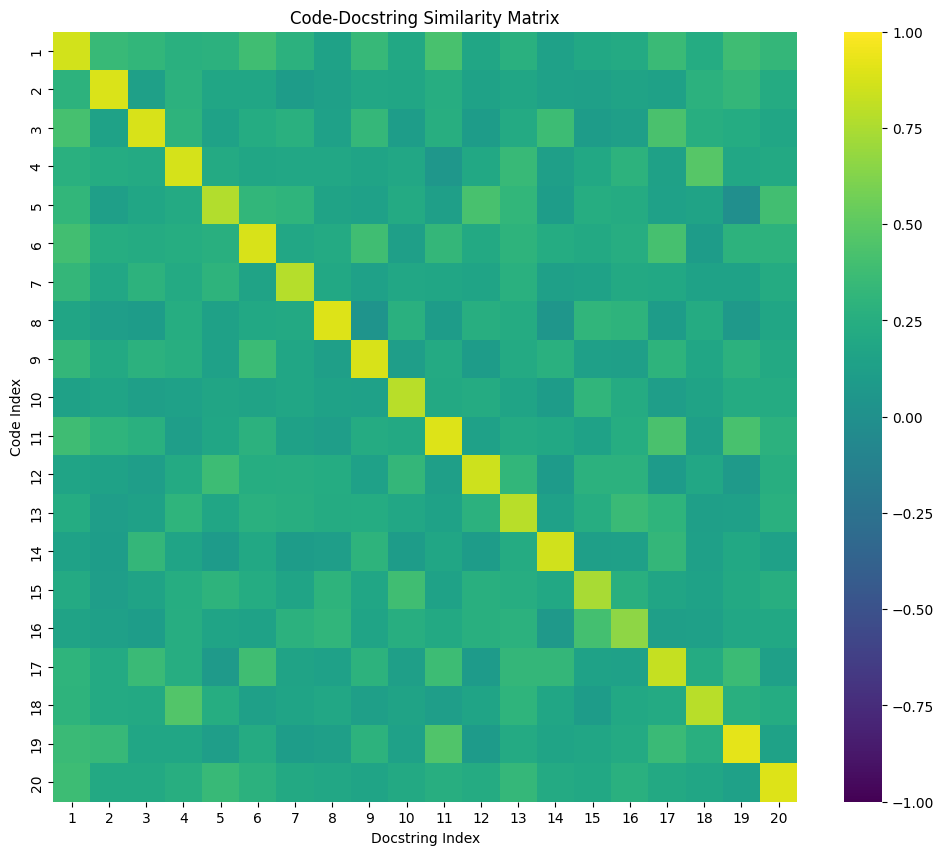

In [23]:
# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_matrix, 
            cmap='viridis', 
            vmin=-1, 
            vmax=1,
            center=0,
            xticklabels=range(1, 21),
            yticklabels=range(1, 21))
plt.title('Code-Docstring Similarity Matrix')
plt.xlabel('Docstring Index')
plt.ylabel('Code Index')
plt.show()

In [25]:
print("\nDiagonal similarities (same code-docstring pairs):")
diagonal_similarities = similarity_matrix.diagonal()
for i, sim in enumerate(diagonal_similarities):
    print(f"Pair {i+1}: {sim:.4f}")

# Print average diagonal vs off-diagonal similarity
diagonal_mean = np.mean(diagonal_similarities)
off_diagonal_mean = np.mean(similarity_matrix[~np.eye(similarity_matrix.shape[0], dtype=bool)])
print(f"\nAverage diagonal similarity: {diagonal_mean:.4f}")
print(f"Average off-diagonal similarity: {off_diagonal_mean:.4f}")


Diagonal similarities (same code-docstring pairs):
Pair 1: 0.8651
Pair 2: 0.8856
Pair 3: 0.8784
Pair 4: 0.8696
Pair 5: 0.7665
Pair 6: 0.8778
Pair 7: 0.7765
Pair 8: 0.8970
Pair 9: 0.8817
Pair 10: 0.7818
Pair 11: 0.8964
Pair 12: 0.8454
Pair 13: 0.7856
Pair 14: 0.8519
Pair 15: 0.7411
Pair 16: 0.6590
Pair 17: 0.8259
Pair 18: 0.7843
Pair 19: 0.9201
Pair 20: 0.8920

Average diagonal similarity: 0.8341
Average off-diagonal similarity: 0.2138
